<a href="https://colab.research.google.com/github/itamarKraitman/Brain_Tumor_detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pandas as pd
import os
from google.colab.patches import cv2_imshow
import cv2

import zipfile
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import datasets
from torchvision.transforms import v2
import torch.optim as optim




In [4]:
# Unzipping the data

with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/BrainToumorDataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

### Reading the pictures from the directories

In [5]:
class BrainToumorData(Dataset):
    def __init__(self, data):
        self.labeled_images = []
        if isinstance(data, str):
            data_folder = data
            self.load_from_folder()
        else:
            self.labeled_images = data

        self.transform = v2.Compose([
            v2.RandomResizedCrop(size=(256,256), antialias=True),
            v2.RandomRotation(45),
            v2.RandomZoomOut(p=0.2)
        ])

    def load_from_folder(self):
        inner_folders = ['yes', 'no']
        image_data = []
        # Loop through each inner folder
        for folder in inner_folders:
            # Get the inner folder path
            folder_path = os.path.join(data_folder, folder)

            # Get the list of files in the folder
            files = os.listdir(folder_path)

            # Create touples with image and it's label
            #labeled_images = [(os.path.join(file,), folder) for file in files]
            for image_path in files:
                image_inner_path = os.path.join(folder, image_path)
                full_image_path = os.path.join(data_folder, image_inner_path)
                # image = cv2.imread(full_image_path)
                # converted_image = preprocesing_image(image)
                self.labeled_images.append((full_image_path, folder))

    def __len__(self):
        return len(self.labeled_images)

    def __getitem__(self, item):
        image_path, label = self.labeled_images[item]
        image = cv2.imread(image_path)

        resized_image = cv2.resize(image, (256, 256))
        normalized_image = resized_image / 255.0
        # converting image to tensor, and adding channel to make it gray scale by changing the first channel to 1
        # 225,225 -> 1,225,225
        if len(normalized_image) == 2:
          image = torch.from_numpy(normalized_image).unsqueeze(0)
        else:
          #RGB case- h,w,3 -> 3,h,w
          image = torch.from_numpy(normalized_image).permute((2,0,1))

        label = 0 if label == "no" else 1

        # augmentation- take augmented image in 20%
        prob = torch.rand(1) < 0.2
        if prob:
          image = self.transform(image)

        return image, label


In [6]:
data_folder = 'brain_tumor_dataset'

data = BrainToumorData(data_folder)

In [7]:
print(f"label of first: {data[0][1]}, label of last: {data[-1][1]}")

label of first: 1, label of last: 0


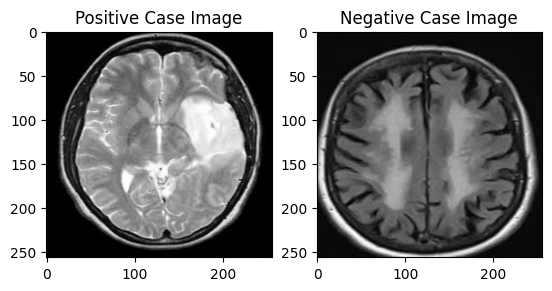

In [8]:
positive_image = data[0][0]
negative_image = data[-1][0]

fix, axs = plt.subplots(1, 2)
axs[0].imshow(positive_image.permute(1,2,0))
axs[0].set_title('Positive Case Image')

axs[1].imshow(negative_image.permute(1,2,0))
axs[1].set_title('Negative Case Image')

plt.show()

In [9]:
print(len([image for image in data if image[1] == 1]))
print(len([image for image in data if image[1] == 0]))

155
98


#### Creating Resnet

In [22]:
def save_current_state(epoch, model, optimizer, val_loss, path):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            }, path)

def load_current_state(path, model, optimizer):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  val_loss = checkpoint['loss']
  return model, optimizer, epoch, val_loss

In [10]:
class ResnetBlock(nn.Module):
  """ """

  def __init__(self, num_channels, num_convs):
    super(ResnetBlock, self).__init__()
    self.layers = nn.ModuleList([]) # knows that the list contains modules which should be trained

    # creating layers
    for i in range(num_convs):
      # can be done inside the layers init but it is here for documentation
      # in resNent input and output channels are the same, kernel is 3*3 and padding 1 for edges
      layer = nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, padding=1)
      self.layers.append(layer)

    self.activation = nn.ReLU()

  # x= input
  def forward(self, x):
    # cloning x data (not reference)
    input = x.clone()

    for layer in self.layers:
      x = layer(x) # moving in the conv layer
      x = self.activation(x) # applying activation function

    x += input
    return x

In [11]:
class Resnet(nn.Module):
  """ """
  def __init__(self, num_init_convs, num_resnet_blocks, fc_channels=128 ,init_channels=32, num_labels=2):
    super(Resnet, self).__init__()

    self.layers = nn.ModuleList([])

    # creating conv layers, placed before all resnet blocks, to upsample channels from 3 to required number of channels
    for i in range(num_init_convs):
      if i == 0:
        in_channles = 3
      else:
        in_channles = init_channels * i

      # 3->32, 32->64, ...
      layer = nn.Conv2d(in_channels=in_channles, out_channels= init_channels * (i + 1), kernel_size=3, padding=1)
      self.layers.append(layer)

    # creating resnet blocks
    self.resnet_blocks = nn.ModuleList([ResnetBlock(num_channels=init_channels * num_init_convs, num_convs=3) for i in range(num_resnet_blocks)])

    self.activation = nn.ReLU()

    fc_channels_in = ((2 ** (8 - num_resnet_blocks)) ** 2) * (init_channels * num_init_convs)

    self.fc1 = nn.Linear(fc_channels_in, fc_channels)

    self.fc2 = nn.Linear(fc_channels, num_labels)



  def forward(self, x):
    # for init conv layers
    for layer in self.layers:
      x = layer(x) # moving in the conv layer
      x = self.activation(x) # applying activation function

    # for resnet blocks
    for layer in self.resnet_blocks:
      x = layer(x)
      x = torch.nn.functional.interpolate(x, scale_factor=0.5, mode='bilinear')

    # flatten x, from the second dimension- do not look at the batch itself (batch, ->c, h, w)
    x = torch.flatten(x, 1)

    # first fc layer
    x = self.fc1(x)
    x = self.activation(x)

    # second fc layer
    x = self.fc2(x)

    return x



In [12]:
PATH = 'C:\Users\itama\OneDrive\Desktop\לימודים שונות\Tumour Detection\current_model_state.pt'

class train_resnet():
  """"""
  def __init__(self, resnet_model, train_set, val_set, criterion=None ,optimizer=None, learning_rate=0.000001, epochs=30):
    self.resnet_model = resnet_model
    self.criterion = nn.CrossEntropyLoss() if criterion is None else criterion # default for loss and optimizer
    self.optimizer = optim.Adam(resnet_model.parameters(), learning_rate) if optimizer is None else optimizer
    self.num_epochs = epochs
    self.batch_size = train_set.batch_size # how can i be detrmine that batch_sizes are the same- could cause exceptions
    self.train_set = train_set
    self.val_set = val_set

  def train_one_epoch(self, epoch_index):
    """Training one epoch"""
    loss = 0.

    for i, data in enumerate(self.train_set):
      inputs, labels = data
      self.optimizer.zero_grad()
      outputs = self.resnet_model(inputs)
      batch_loss = self.criterion(outputs, labels)
      batch_loss.backward()
      self.optimizer.step()
      loss += batch_loss.item()

    return loss / self.batch_size # to get the avarage loss over all batchs

  def validate_one_epoch(self):
    """Validating one epoch"""
    loss = 0.

    with torch.no_grad():
      for i, data in enumerate(self.val_set):
        inputs, labels = data
        outputs = self.resnet_model(inputs)
        batch_loss = self.criterion(outputs, labels)
        loss += batch_loss.item()

    return loss / self.batch_size


  def fit(self):
    min_val_loss = np.inf

    for epoch in range(self.num_epochs):
      # run epoch
      self.resnet_model.train()
      train_loss = self.train_one_epoch(epoch)
      self.resnet_model.eval()
      val_loss = self.validate_one_epoch()

      # print epoch log
      print(f"Epoch {epoch + 1}/{self.num_epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}")

      if val_loss < min_val_loss:
        min_val_loss = val_loss
        path = f'model_{epoch}'
        save_current_state(epoch, self.resnet_model, self.optimizer, val_loss, path)


#### Train-Val-Test Split

In [21]:
len(validation_loader.sampler)

25

In [14]:
train_data, rest_data = train_test_split(data.labeled_images, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(rest_data, test_size=0.5, random_state=42)

# Creating data sets
train_set = BrainToumorData(train_data)
val_dataset = BrainToumorData(val_data)
test_dataset = BrainToumorData(test_data)

# creating DataLoaders for each for training process
train_loader = DataLoader(train_set, batch_size=32, shuffle=True) # shuffeling for training process
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Building ResNet Model

In [ ]:
# 16 ResNet blocks

resnet_model = Resnet(num_init_convs=3, num_resnet_blocks=16)

##### Training and Validating

In [ ]:
def evaluate(model, data_loader):
    """
    Evaluating model performance
    :param model: pyTorch model
    :param data_loader: data
    :return: model accuracy
    """

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            labels_as_tensor = encode_labels(labels)
            outputs = model(inputs)
            # torch.max() returns tensor where the second dimension is the predicted scores for each class
            _, predicted = torch.max(outputs, 1)
            total += len(labels)
            equal_entries = torch.eq(predicted, labels_as_tensor)
            correct += torch.sum(equal_entries).item()

    accuracy = correct / total
    return accuracy

In [ ]:
num_epochs = 30
loss_history, val_loss_history = [], []


def encode_labels(labels):
    encoded_list = [1 if item == 'yes' else 0 for item in labels]

    # Convert the list to a PyTorch tensor
    return torch.tensor(encoded_list)


for epoch in range(num_epochs):
    # Setting the model to training mode
    rsnet_model.train()
    for inputs, labels in train_loader:
        labels_as_tensor = encode_labels(labels)
        # Zeroing out the gradients from previous batch so they won't influence the current batch
        optimizer.zero_grad()
        # Predicting
        outputs = rsnet_model(inputs)
        # Computing loss value
        loss = criterion(input=outputs, target=labels_as_tensor)
        # Backward propagating
        loss.backward()
        # Updating the model parameters based on the gradients computed during the backward pass
        optimizer.step()

    # Validating the model after each epoch
    rsnet_model.eval()
    with torch.no_grad(): # Disabling gradient computation
        for inputs, labels in validation_loader:
            labels_as_tensor_val = encode_labels(labels)
            outputs = rsnet_model(inputs)
            val_loss = criterion(outputs, labels_as_tensor_val)

    # Evaluate validation accuracy
    val_accuracy = evaluate(model=rsnet_model, data_loader=validation_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Val loss: {val_accuracy}")

    loss_history.append(loss.item())
    val_loss_history.append(val_accuracy)

Epoch 1/10, Loss: 0.5731407999992371, Val loss: 0.6445873975753784, val accuracy: 0.6111111111111112
Epoch 2/10, Loss: 0.5138107538223267, Val loss: 0.5066779255867004, val accuracy: 0.8518518518518519
Epoch 3/10, Loss: 0.25411829352378845, Val loss: 0.42142176628112793, val accuracy: 0.8148148148148148
Epoch 4/10, Loss: 0.13657806813716888, Val loss: 0.30384373664855957, val accuracy: 0.9814814814814815
Epoch 5/10, Loss: 0.22356151044368744, Val loss: 0.2932005226612091, val accuracy: 0.8888888888888888
Epoch 6/10, Loss: 0.04756380617618561, Val loss: 0.24740318953990936, val accuracy: 0.9259259259259259
Epoch 7/10, Loss: 0.03633303940296173, Val loss: 0.21262457966804504, val accuracy: 0.9814814814814815
Epoch 8/10, Loss: 0.05061717331409454, Val loss: 0.2156727910041809, val accuracy: 0.9629629629629629
Epoch 9/10, Loss: 0.023959174752235413, Val loss: 0.25121521949768066, val accuracy: 0.9629629629629629
Epoch 10/10, Loss: 0.021309463307261467, Val loss: 0.23918788135051727, val ac

Max accuracy is: 0.9814814814814815
